In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests, json, gmplot
from datetime import datetime
from census import Census
# from us import states
from resources.states import states
from resources.statesAreaInMiles import statesAreaInMiles
import scipy.stats as stats
import plotly as py
from plotly.tools import FigureFactory as FF
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.gridspec import GridSpec
from bs4 import BeautifulSoup
from IPython.core.display import display
from IPython.display import IFrame


py.offline.init_notebook_mode(connected=True)

dt = datetime.today().strftime('%m-%d-%y')
# Extract API key from external json file
keyPairs = open('../../keys/appkey.json')
keyPairs_json = json.load(keyPairs)
gkey = keyPairs_json['gkey']
censuskey = keyPairs_json['censuskey']


## Extract Superfund Sites data

In [2]:
sf = pd.read_csv("resources/superfunddata.csv" , dtype={'Zip': str}) #, "Latitude":float
sf["Latitude"] = sf["Latitude"].str.decode("unicode_escape")
sf["Longitude"] = sf["Longitude"].str.decode("unicode_escape")
sf["Latitude"] = sf["Latitude"].str.encode("ascii", "ignore")
sf["Longitude"] = sf["Longitude"].str.encode("ascii", "ignore")
# delete empty rows at end of file
sf.drop(sf.index[[1336,1337]], inplace=True)
sf["Converted Date"] = ""
for index, row in sf.iterrows():
    sf.set_value(index, "Converted Date", datetime.strptime(row["Final Date"], '%m/%d/%y'))
sf["Year"]=""
for index, row in sf.iterrows():
    sf.set_value(index, "Year", row["Converted Date"].year)
sf.head()

,Reg,St,Site Name,Unnamed: 3,Site ID,EPA ID,Address,City,Zip,County,Unnamed: 10,Unnamed: 11,FF?,Latitude,Longitude,Final Date,Unnamed: 16,Unnamed: 17,Converted Date,Year
0,‭01‬,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,NaN,‭0100255‬,CTD980732333,ROUTE 44,BARKHAMSTED,06063,LITCHFIELD,NaN,NaN,N,b'+41.980550',b'-073.047220 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
1,‭01‬,CT,BEACON HEIGHTS LANDFILL,NaN,‭0100180‬,CTD072122062,BLACKBERRY HILL ROAD,BEACON FALLS,06403,NEW HAVEN,NaN,NaN,N,b'+41.431950',b'-073.035280 ',09/08/83,NaN,NaN,1983-09-08 00:00:00,1983
2,‭01‬,CT,DURHAM MEADOWS,NaN,‭0100108‬,CTD001452093,124 MAIN ST,DURHAM,06422,MIDDLESEX,NaN,NaN,N,b'+41.481110',b'-072.681380 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
3,‭01‬,CT,GALLUP'S QUARRY,NaN,‭0100201‬,CTD108960972,ROUTE 12,PLAINFIELD,06374,WINDHAM,NaN,NaN,N,b'+41.665280',b'-071.924160 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
4,‭01‬,CT,KELLOGG-DEERING WELL FIELD,NaN,‭0100252‬,CTD980670814,NORWALK WATER DEPARTMENT,NORWALK,06856,FAIRFIELD,NaN,NaN,N,b'+41.130550',b'-073.431950 ',09/21/84,NaN,NaN,1984-09-21 00:00:00,1984


## Find Superfund sites per State

In [3]:
## Extract statewise superfund site count, add state names against abbreviations & area of states in sq. miles 
sitesPerState = sf.groupby('St').count()
sitesPerState = sitesPerState.reset_index()
sitesPerState = sitesPerState[['St','Reg']]
sitesPerState = sitesPerState.rename(columns= {'St':'Code','Reg':'No. Of SF Sites'})
for state in states:
    if state not in sitesPerState['Code'].tolist():
        nxtIdx = len(sitesPerState)
        sitesPerState.set_value(nxtIdx, 'Code', state)
        sitesPerState.set_value(nxtIdx, 'No. Of SF Sites', 0)

sitesPerState['Name'] = sitesPerState['Code'].map(states.get)
sitesPerState['Area Sq Miles'] = sitesPerState['Name'].map(statesAreaInMiles.get)
sitesPerState['No. Of Sites Per Sq Miles'] = sitesPerState['No. Of SF Sites'].astype('float') / sitesPerState['Area Sq Miles'].astype('float')
sitesPerState.dropna(inplace=True)
sitesPerState.head()

,Code,No. Of SF Sites,Name,Area Sq Miles,No. Of Sites Per Sq Miles
0,AK,6.0,Alaska,571951.26,0.000010
1,AL,12.0,Alabama,50744.00,0.000236
2,AR,9.0,Arkansas,52068.17,0.000173
3,AZ,9.0,Arizona,113634.57,0.000079
4,CA,98.0,California,155959.34,0.000628


## Data munging (cleanse)

In [4]:
## Remove unwanted/blank columns, create list of latitudes & longitudes
# This data is needed for plotting on google map
sf.drop(['Unnamed: 3','Unnamed: 10','Unnamed: 11','Unnamed: 16','Unnamed: 17'], axis=1,inplace=True)
sfFilterLatLon = sf.copy()
sfFilterLatLon.drop(sfFilterLatLon.index[[756,1104]], inplace=True)
sfFilterLatLon.dropna(subset=[['Latitude','Longitude']],inplace=True)
sfFilterLatLon.reset_index(inplace=True)
latitudes = pd.to_numeric(sfFilterLatLon['Latitude'])
longitudes = pd.to_numeric(sfFilterLatLon['Longitude'])
sfFilterLatLon['Site Name'] = sfFilterLatLon['Site Name                                                                ']
sitename = sfFilterLatLon['Site Name'].tolist()

## Extract Census data for 2015 for all US zip codes

In [5]:
c = Census(censuskey, year=2015)
censusByZipCd2015 = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_002E", "B23025_007E", "B23025_003E", "B23025_004E", "B23025_005E", "B23025_006E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B15003_002E", "B15003_017E", "B15003_018E", "B15003_021E", "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
censusByZipCd2015_df = pd.DataFrame(censusByZipCd2015)
censusByZipCd2015_df.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,...,C24010_066E,C24010_067E,C24010_068E,C24010_069E,C24010_070E,C24010_071E,C24010_072E,C24010_073E,NAME,zip code tabulation area
0,37.6,36.5,39,17982,16956,102,14,0,0,64,...,14,0,0,14,125,110,0,15,ZCTA5 00601,00601
1,39.5,38.6,40.3,40260,23144,693,8,72,0,14798,...,15,0,0,15,376,334,0,42,ZCTA5 00602,00602
2,39.9,37.7,41.4,52408,36177,2057,76,655,0,7801,...,43,0,11,32,211,128,0,83,ZCTA5 00603,00603
3,40.8,41,40.3,6331,4399,151,0,0,0,126,...,15,0,0,15,93,93,0,0,ZCTA5 00606,00606
4,40.2,36.9,42.2,28328,17791,950,0,26,0,3355,...,0,0,0,0,788,738,15,35,ZCTA5 00610,00610


## Extract Census data for 2015 for all US States

In [6]:
censusByStates2015 = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B19301_001E", "B25077_001E"), {'for': 'state:*'})
censusByStates2015_df = pd.DataFrame(censusByStates2015)
censusByStates2015_df = censusByStates2015_df.rename(columns={"B01003_001E": "Population", 
                                                              "B19013_001E": "Household Income",
                                                              "B19301_001E": "Per Capita Income",
                                                              "B25077_001E": "Median House Price",
                                                              "NAME": "Name", "state": "State"})
censusByStates2015_df.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State
0,733375,72515,33413,250000,Alaska,02
1,4830620,43623,24091,125500,Alabama,01
2,2958208,41371,22798,111400,Arkansas,05
3,6641928,50255,25848,167500,Arizona,04
4,38421464,61818,30318,385500,California,06


## Merge Census data for States with Superfund sites data per State

In [7]:
censusStateAndSFSites = pd.merge(censusByStates2015_df,sitesPerState,on='Name')
censusStateAndSFSites['Population Density'] = censusStateAndSFSites['Population'].astype('int') / censusStateAndSFSites['Area Sq Miles'].astype('float')
censusStateAndSFSites.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State,Code,No. Of SF Sites,Area Sq Miles,No. Of Sites Per Sq Miles,Population Density
0,733375,72515,33413,250000,Alaska,02,AK,6.0,571951.26,0.000010,1.282233
1,4830620,43623,24091,125500,Alabama,01,AL,12.0,50744.00,0.000236,95.195885
2,2958208,41371,22798,111400,Arkansas,05,AR,9.0,52068.17,0.000173,56.814134
3,6641928,50255,25848,167500,Arizona,04,AZ,9.0,113634.57,0.000079,58.449889
4,38421464,61818,30318,385500,California,06,CA,98.0,155959.34,0.000628,246.355646


## Plot Statewise Superfund Sites density and Population density

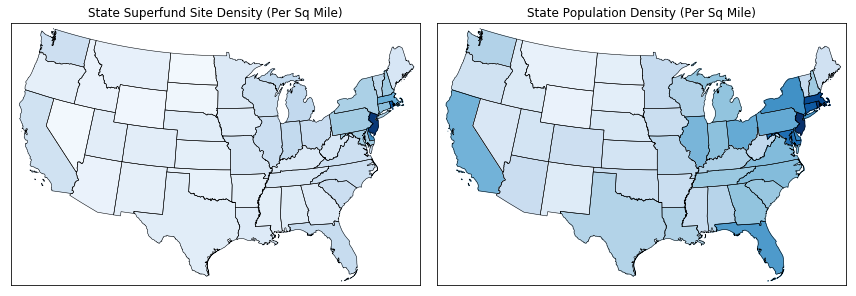

In [8]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('resources/st99_d00','states',drawbounds=True)
colors={}
statenames=[]
cmap = plt.cm.Blues_r
vmin = 0.000001; vmax = censusStateAndSFSites["No. Of Sites Per Sq Miles"].max() / censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico and the ones which are already processed. Process all from state_list of sitesPerSt
    if ((statename not in ['District of Columbia','Puerto Rico']) and (statename not in statenames) and (statename in censusStateAndSFSites["Name"].tolist())):
        if (int(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["No. Of SF Sites"])) == 0:
            pop = 0.00001/censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()
        else:
            pop = float(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["No. Of Sites Per Sq Miles"]) / censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if (statenames[nshape] not in ['District of Columbia','Puerto Rico']):
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

plt.title('State Superfund Site Density (Per Sq Mile)')


plt.subplot(1,2,2)
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('resources/st99_d00','states',drawbounds=True)
colors={}
statenames=[]
cmap = plt.cm.Blues_r
vmin = censusStateAndSFSites["Population Density"].min()/censusStateAndSFSites["Population Density"].sum(); vmax = censusStateAndSFSites["Population Density"].max()/censusStateAndSFSites["Population Density"].sum()

for shapedict in m.states_info:
    statename = shapedict['NAME']
    if (statename not in ['District of Columbia','Puerto Rico']) and (statename not in statenames) and (statename in censusStateAndSFSites["Name"].tolist()):
        pop = (int(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["Population Density"]) * 10 / censusStateAndSFSites["Population Density"].sum())
        colors[statename] = cmap(1.-np.sqrt(((pop-vmin)/(vmax-vmin))))[:3]
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.title('State Population Density (Per Sq Mile)')

plt.tight_layout()
plt.show()

In [9]:
censusStateAndSFSites.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State,Code,No. Of SF Sites,Area Sq Miles,No. Of Sites Per Sq Miles,Population Density
0,733375,72515,33413,250000,Alaska,02,AK,6.0,571951.26,0.000010,1.282233
1,4830620,43623,24091,125500,Alabama,01,AL,12.0,50744.00,0.000236,95.195885
2,2958208,41371,22798,111400,Arkansas,05,AR,9.0,52068.17,0.000173,56.814134
3,6641928,50255,25848,167500,Arizona,04,AZ,9.0,113634.57,0.000079,58.449889
4,38421464,61818,30318,385500,California,06,CA,98.0,155959.34,0.000628,246.355646


## Plot Superfund Site counts and Census data on US Map

In [10]:
censusStateAndSFSitesStr = censusStateAndSFSites.copy()
for col in censusStateAndSFSitesStr.columns:
    censusStateAndSFSitesStr[col] = censusStateAndSFSitesStr[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

censusStateAndSFSitesStr['text'] = censusStateAndSFSitesStr['Name'] + '<br>' +\
    'No. Of Sites/Sq Mile: '+censusStateAndSFSitesStr['No. Of Sites Per Sq Miles']+ '<br>' +\
    'Population/Sq Mile: '+censusStateAndSFSitesStr['Population Density']+ '<br>' +\
    'Household Income: '+censusStateAndSFSitesStr['Household Income'] + '<br>' +\
    'Per Capita Income: '+censusStateAndSFSitesStr['Per Capita Income'] + '<br>' +\
    'Median House Price: '+censusStateAndSFSitesStr['Median House Price']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = censusStateAndSFSitesStr['Code'],
        z = censusStateAndSFSitesStr['No. Of SF Sites'].astype(float),
        locationmode = 'USA-states',
        text = censusStateAndSFSitesStr['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "No Of Sites")
        ) ]

layout = dict(
        title = 'Number of Superfund sites as of 2016<br> [Hover for breakdown]',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.offline.iplot( fig, filename='d3-cloropleth-map' )


In [11]:
#Function to update Google api key in code for code generated by gmplot
def insertapikey(fname, apikey):
    """put the google api key in a html file"""
    def putkey(htmltxt, apikey, apistring=None):
        """put the apikey in the htmltxt and return soup"""
        if not apistring:
            apistring = "https://maps.googleapis.com/maps/api/js?key=%s&callback=initMap"
        soup = BeautifulSoup(htmltxt, 'html.parser')
        body = soup.body
        src = apistring % (apikey, )
        tscript = soup.new_tag("script", src=src, async="defer")
        body.insert(-1, tscript)
        return soup
    htmltxt = open(fname, 'r').read()
    soup = putkey(htmltxt, apikey)
    newtxt = soup.prettify()
    open(fname, 'w').write(newtxt)

## Plot all Superfund sites on Google map 

In [12]:
fname = "allSFSites.html"
gmap = gmplot.GoogleMapPlotter(37.428, -95.145, 4)
for x in range(len(longitudes)):
    gmap.circle(latitudes[x],longitudes[x], 3000, "r", ew=1)
gmap.draw(fname)  

insertapikey(fname, gkey)
display(IFrame(fname, width=800, height=400))

In [13]:
cur_addr = "300 atrium drive somerset nj"
target_url = "https://maps.googleapis.com/maps/api/geocode/json" \
    "?address=%s&key=%s" % (cur_addr, gkey)
geo_data = requests.get(target_url).json()
lat = geo_data["results"][0]["geometry"]["location"]["lat"]
lon = geo_data["results"][0]["geometry"]["location"]["lng"]

## Plot markers for all Superfund sites near a specific location

### (300 Atrium Drive, Somerset, NJ)

In [14]:
gmap = gmplot.GoogleMapPlotter(lat, lon, 12)
for x in range(len(longitudes)):
    gmap.marker(latitudes[x],longitudes[x], title=sitename[x])
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"
gmap.draw(fname) 

insertapikey(fname, gkey)
display(IFrame(fname, width=800, height=400))

## Extract Census data of 2011 to 2015 for all US zip codes

In [15]:
census_df_all = pd.DataFrame([])
yrs = [2011,2012,2013,2014,2015]
for x in yrs:
    c = Census(censuskey, year=x)
    census_df_tmp = pd.DataFrame([])
    census_df_tmp['Year'] = ""
    # removed following as not available for all years - B23025_002E, B23025_007E, B23025_003E, B23025_004E, B23025_005E, B23025_006E, B15003_002E, B15003_017E, B15003_018E, B15003_021E, B15003_022E, B15003_023E, B15003_024E, B15003_025E
    census_data = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
    census_df_tmp = pd.DataFrame(census_data)
    census_df_tmp['Year'] = x
    census_df_all = census_df_all.append(census_df_tmp)
census_df_all.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,...,C24010_067E,C24010_068E,C24010_069E,C24010_070E,C24010_071E,C24010_072E,C24010_073E,NAME,zip code tabulation area,Year
0,44.1,42.7,45.6,16775,15996,259,17,98,0,144,...,0,0,0,187,125,62,0,ZCTA5 01001,01001,2011
1,23.8,23.3,24.5,27684,21922,1190,99,3317,0,845,...,19,57,46,152,88,44,20,ZCTA5 01002,01002,2011
2,19.9,20,19.9,11516,9574,636,0,945,3,265,...,0,6,29,366,300,22,44,ZCTA5 01003,01003,2011
3,42.8,42.6,43.3,5045,4953,6,9,63,0,0,...,0,0,0,100,64,0,36,ZCTA5 01005,01005,2011
4,40.5,38.1,42.1,14479,13619,188,0,185,0,280,...,15,9,45,111,54,45,12,ZCTA5 01007,01007,2011


In [16]:
zips, population, house_value, age, capita, income, poverty, year = [[] * 8 for x in range(8)]
for index, row in sf.iterrows():
    if row["Converted Date"].year == int("2009"):
        zips.append(row["Zip"])
for index, row in census_df_all.iterrows():
    for code in zips:
        if (code == row["zip code tabulation area"]):
            population.append(row['B01003_001E'])
            house_value.append(row['B25077_001E'])
            age.append(row['B01002_001E'])
            capita.append(row['B19301_001E'])
            income.append(row['B19013_001E'])
            poverty.append(row['B17001_002E'])
            year.append(row["Year"])

sf_census = pd.DataFrame({
    "Population":population,
    "House Value":house_value,
    "Age":age,
    "Per Capita Income":capita,
    "Income":income,
    "Number Below Poverty":poverty,
    "Year":year
})
new_sf = sf_census.apply(pd.to_numeric)
five_year_sf = new_sf.groupby("Year").mean()

norm_census = pd.DataFrame({
    "Population":census_df_all["B01003_001E"],
    "House Value":census_df_all["B25077_001E"],
    "Age":census_df_all["B01002_001E"],
    "Per Capita Income":census_df_all["B19301_001E"],
    "Income":census_df_all["B19013_001E"],
    "Number Below Poverty":census_df_all["B17001_002E"],
    "Year":census_df_all["Year"]
})
norm_census = norm_census.apply(pd.to_numeric)
five_year_norm = norm_census.groupby("Year").mean()

## Socio-Economic trends Superfund Sites vs National (2011-2015)

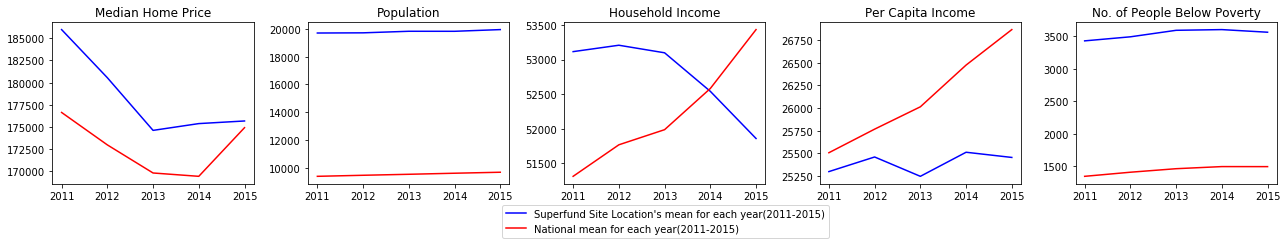

In [17]:
plt.figure(figsize=(18,3))
plt.subplot(1,5,1)
plt.plot(five_year_sf.index,five_year_sf["House Value"], c='b')
plt.plot(five_year_norm.index, five_year_norm["House Value"],c='r')
plt.title("Median Home Price")
plt.subplot(1,5,2)
plt.plot(five_year_sf.index,five_year_sf["Population"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Population"],c='r')
plt.title("Population")
plt.subplot(1,5,3)
plt.plot(five_year_sf.index,five_year_sf["Income"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Income"],c='r')
plt.title("Household Income")
plt.subplot(1,5,4)
plt.plot(five_year_sf.index,five_year_sf["Per Capita Income"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Per Capita Income"],c='r')
plt.title("Per Capita Income")
plt.subplot(1,5,5)
plt.plot(five_year_sf.index,five_year_sf["Number Below Poverty"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Number Below Poverty"],c='r')
plt.title("No. of People Below Poverty")
plt.tight_layout()
label1 = ["Superfund Site Location's mean for each year(2011-2015)","National mean for each year(2011-2015)"]
plt.legend(labels=label1, bbox_to_anchor=(-1.2, -0.1))
plt.show()

## Crosstab Superfund data to get counts of adds for each state (5 year slots)

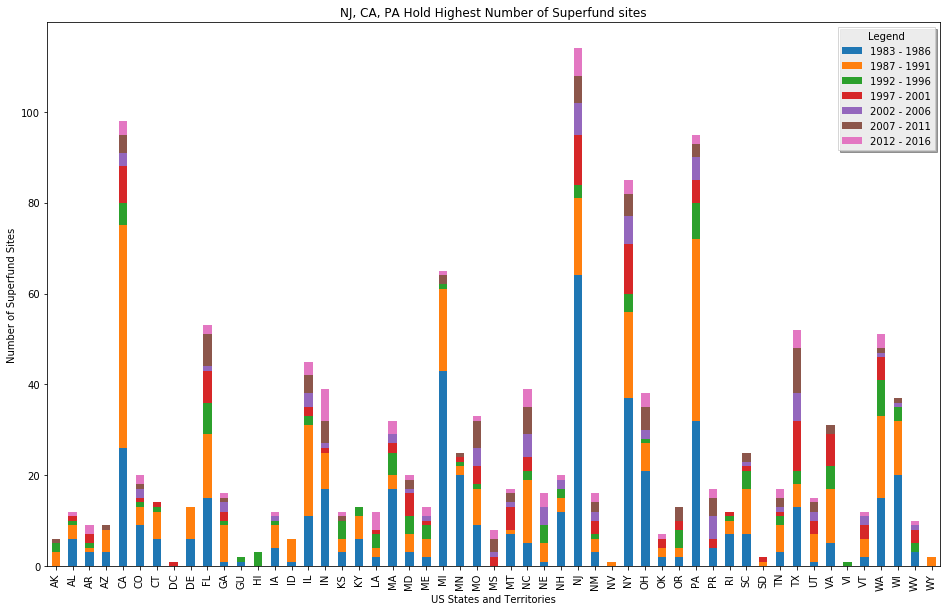

In [18]:
yearRange = [1983, 1987, 1992, 1997, 2002, 2007, 2012, 2017]
rangeLabel = []
for index, x in enumerate(yearRange):
    if index == 0:
        rangeLabel.append(str(x) + " - " + str(x+3))
    elif index != len(yearRange)-1:
        rangeLabel.append(str(x) + " - " + str(x+4)) 
rangeLabel
sf["YearRange"] = pd.cut(sf["Year"], yearRange, labels=rangeLabel, include_lowest=True, right=False)
sf[sf["YearRange"]=="2012 - 2016"].sort_values("Year")
stateYear = pd.crosstab(sf['St'], sf['YearRange'])

stateYear.plot(kind="bar", stacked=True, figsize=(16,10))
plt.legend(bbox_to_anchor=(1,1),
           ncol=1, shadow=True, title="Legend", fancybox=False)
plt.title("NJ, CA, PA Hold Highest Number of Superfund sites")
plt.ylabel("Number of Superfund Sites")
plt.xlabel("US States and Territories")
plt.show()

## Merge superfund and census 2015 data

In [19]:
sfcensus = sf.merge(censusByZipCd2015_df, how="left", left_on="Zip", right_on="zip code tabulation area")
len(sfcensus)

1336

In [20]:
sfcensus.drop_duplicates(subset='Zip', keep="last", inplace=True)
len(sfcensus)

1156

## Population segment analysis

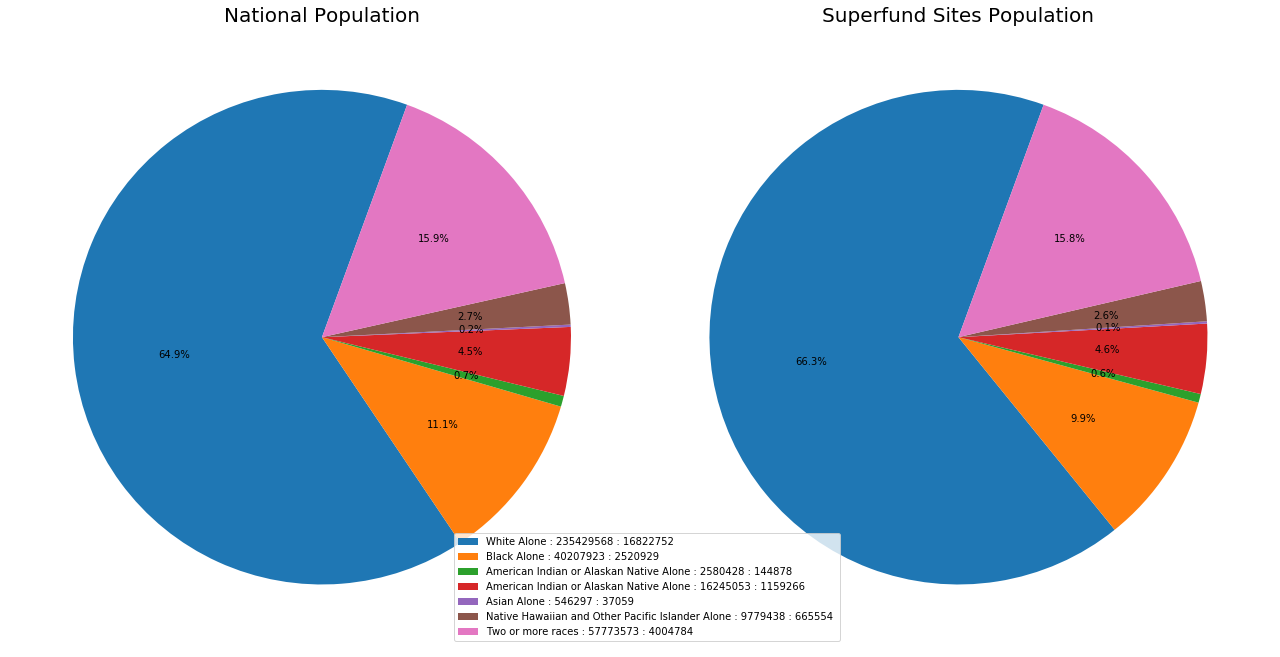

In [21]:
# "B02001_002E" White alone
# "B02001_003E" Black alone
# "B02001_004E" American Indian or Alaskan Native Alone
# "B02001_005E" Asian alone
# "B02001_006E" Native Hawaiian and Other Pacific Islander Alone
# "B02001_008E" Two or more races
# "B03001_003E" Hispanic Origin

popList = ("B02001_002E","B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E")
popLabels = ["White Alone", "Black Alone","American Indian or Alaskan Native Alone","American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]

nationalPopCount = []
for p in popList:
    nationalPopCount.append(pd.to_numeric(censusByZipCd2015_df[p]).sum())
    
sfPopCount = []
for p in popList:
    sfPopCount.append(pd.to_numeric(sfcensus[p]).sum())

fig = plt.figure(figsize=(18,18))
the_grid = GridSpec(2,2)

ax1 = fig.add_subplot(the_grid[0,0])
nationalPopSeries = pd.Series(nationalPopCount)
patches, texts,autotexts = ax1.pie(nationalPopSeries, autopct='%1.1f%%', startangle = 70)
ax1.set_title("National Population", size=20)

ax2 = fig.add_subplot(the_grid[0,1])
sfPopSeries = pd.Series(sfPopCount)
patches, texts,autotexts = ax2.pie(sfPopSeries, autopct='%1.1f%%', startangle = 70)
ax2.set_title("Superfund Sites Population", size=20)

label1 = ['{0} : {1:1d} : {2:1.0f} ' .format(x,y,z) for x,y,z in zip(popLabels, nationalPopCount, sfPopCount)]
plt.legend(loc='lower center', labels=label1, bbox_to_anchor=(0, 0))
plt.tight_layout(pad=1.5, w_pad=0.7, h_pad=0.5)
plt.show()